<a href="https://colab.research.google.com/github/wrxwrxsti/fastai-learnathon-pet-breed-classifier/blob/main/pet_breed_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/walkwithfastai.png?raw=true)
# 🐶 My FastAI Model – Pet Breed Classifier

## 🧠 What this model does
This notebook trains a deep learning model using FastAI to classify pet breeds from images.

---

## 📦 Dataset
I(Waris) used the Oxford-IIIT Pet Dataset, which includes various dog and cat breeds.

---

## 🎯 Training Strategy
Started with a ResNet34 model, then upgraded to ResNet50. Fine-tuned for 2 epochs with unfreezing.

---

## 💾 Export
Saved the trained model using `learn.export('pet_breeds_model.pkl')`.


# Let's grab the library:

In [1]:
#Run once per session
!pip install fastai -q --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.4 MB/s eta 0:00:00


Now we can import the `fastai` libraries (fastai 2.0!)

Today we will be using the `basics`, `callback`, and `vision` libraries as we have a **vision** task

In [2]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

Overall process using machine learning models and fastai:
1. Make our `DataLoaders`
2. Make a `Learner` with some "equipment"
3. Train

## Looking at Data

We'll be trying to identify between 12 species of cats and 25 species of dogs (37 in total). Five years ago, the best was 59% with seperate classifications for the image, head, and body of the animal. Let's try just doing one image for everything.

But before anything, we need data!

In [4]:
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url: 'str', archive: 'Path' = None, data: 'Path' = None, c_key: 'str' = 'data', force_download: 'bool' = False, base: 'str' = None) -> 'Path'
    Download `url` using `FastDownload.get`



In [5]:
untar_data??

Let's download the dataset

In [6]:
path = untar_data(URLs.PETS)

And set our seed

In [7]:
np.random.seed(2)

How will our data look?

In [8]:
path.ls()[:3]

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

Let's build a `DataLoaders`.

In [9]:
path = untar_data(URLs.PETS)
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'

Some  basic transforms

In [10]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
bs=64

`ImageDataBunch` (renamed to ImageDataLoaders) - highest level API

In [11]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms,
                                   item_tfms=item_tfms, bs=bs)

What is the API?

* See PPT

Let's rebuild using the `DataBlock` api - Medium Level

In [12]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [13]:
path_im = path/'images'

In [14]:
dls = pets.dataloaders(path_im, bs=bs)

We can take a look at a batch of our images using `show_batch` and pass in a aximum number of images to show, and how large we want to view them as

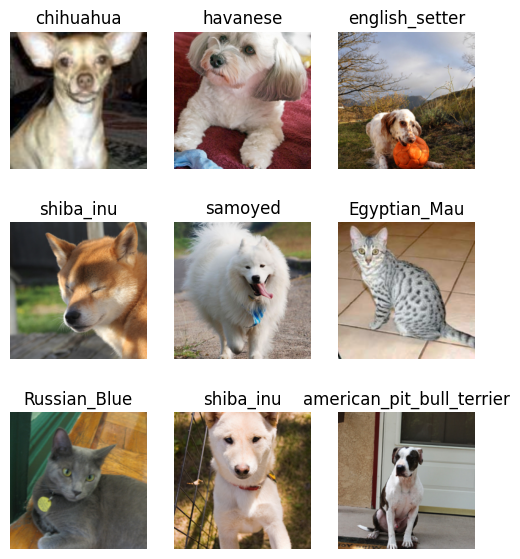

In [15]:
dls.show_batch(max_n=9, figsize=(6,7))

If we want to see how many classes we have, and the names of them we can simply call `dls.vocab`. The first is the number of classes, the second is the names of our classes. You may notice this looks a bit odd, that's because this `L` is a new invention of Jeremy and Sylvian. Essentially it's a Python list taken to the extreme.

Before if we wanted to grab the index for the name of a class (eg. our model output 0 as our class), we would need to use `data.c2i` to grab the Class2Index mapping. This is still here, it lives in `dls.vocab.o2i`

In [16]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [17]:
dls.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

## Time to make and train a model!

We will be using a convolutional neural network backbone and a fully connected head with a single hidden layer as our classifier. Don't worry if thats a bunch of nonsense for now. Right now, just know this: we are piggybacking off of a model to help us classify images into 37 categories.

First, we need to make our Neural Network and our `Learner` like before.

A `Learner` needs (on a base level):

* `DataLoaders`
* Some architecture
* A evaluation metric
* A loss function
* An optimizer

We'll also use `mixed_precision` (`fp16`)

In [18]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 147MB/s]


Some assumptions being made here:

* Loss function is assumed as classification, so `CrossEntropyFlat`
* Optimizer is assumed to be Adam

Now, we can train it! We will train it for four cycles through all our data

In [19]:
learn.fit_one_cycle(4)

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,1.903742,0.355731,0.113667,00:58
1,0.679493,0.264613,0.083221,00:56
2,0.374496,0.233269,0.079161,00:55
3,0.297957,0.223420,0.079161,00:57


In [20]:
learn.save('stage_1')

Path('models/stage_1.pth')

## Lets look at our results

With the model trained, let's look at where our it might've messed up. What species did it have trouble differentiating between? So long as the misidentifications are not too crazy, our model is actually working.

Let's plot our losses and make a confusion matrix to visualize this. Below checks to make sure that all pieces we need are available

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

`plot_top_losses` needs `x` number of images to use, and a figure size.

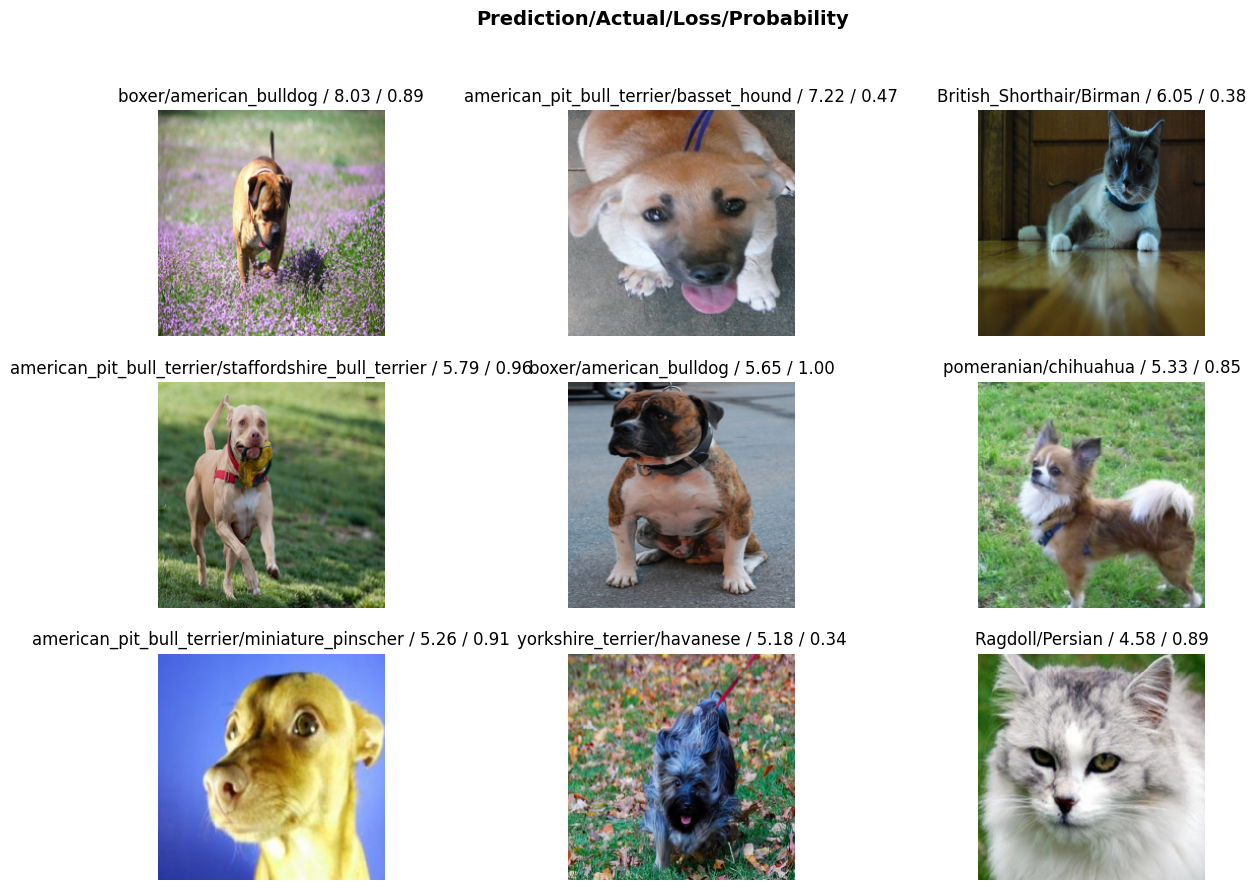

In [22]:
interp.plot_top_losses(9, figsize=(15,10))

`plot_confusion_matrix` just needs a figure size. dpi adjusts the quality

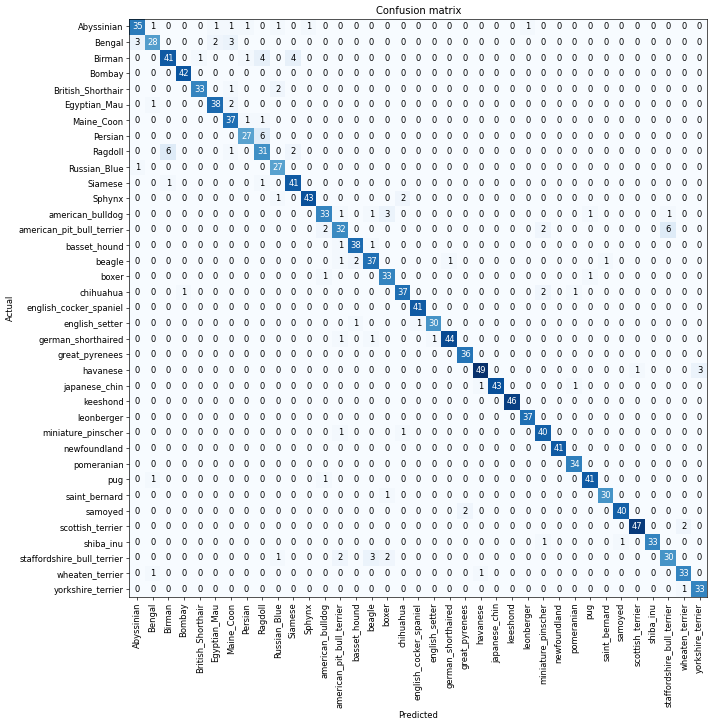

In [23]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

We can also directly grab our most confused (A raw version of the confusion matrix), and pass in a threshold

In [24]:
interp.most_confused(min_val=3)

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


[('Persian', 'Ragdoll', np.int64(6)),
 ('Ragdoll', 'Birman', np.int64(6)),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', np.int64(6)),
 ('Birman', 'Ragdoll', np.int64(4)),
 ('Birman', 'Siamese', np.int64(4)),
 ('Bengal', 'Abyssinian', np.int64(3)),
 ('Bengal', 'Maine_Coon', np.int64(3)),
 ('american_bulldog', 'boxer', np.int64(3)),
 ('havanese', 'yorkshire_terrier', np.int64(3)),
 ('staffordshire_bull_terrier', 'beagle', np.int64(3))]

## Unfreezing our data, fine-tuning, and our learning rates

So, we have the model. Let's fine tune it. First, we need to load our model back in.

In [27]:
learn.load('stage_1'); # optional / not used in this run

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

Now we will *unfreeze* and train more

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.167101,2.422359,0.557510,00:59
1,1.042318,1.095052,0.322057,00:57
2,0.624286,0.534621,0.168471,00:59
3,0.310859,0.415680,0.127199,00:57


Now when we `unfreeze`, we unfreeze *all* the layers. So to show how a difference of a proper learning rate looks, let's load in those old weights and try using `lr_find()`

In [30]:
learn.load('stage_1'); # optional / not used in this run

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

SuggestedLRs(valley=0.00013182566908653826)

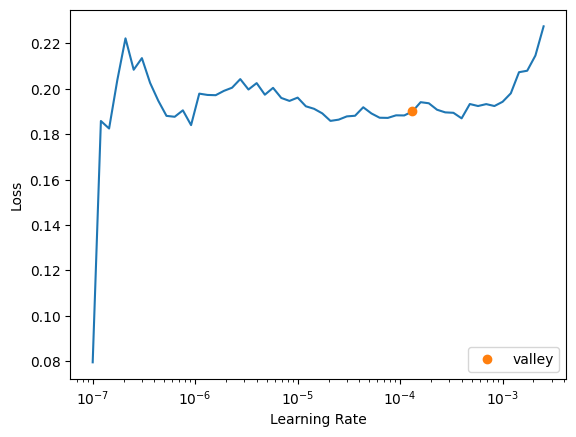

In [31]:
learn.lr_find()

Alright so if we look here, we don't start really spiking our losses until ~10^-2 so a good spot is between 1e-6 and 1e-4, let's do that!

In [32]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.209504,0.401301,0.121786,00:58
1,0.190970,0.389178,0.121786,00:57
2,0.177369,0.395931,0.121786,00:59
3,0.163532,0.387657,0.123139,00:57


We can see that picking a proper learning rate can help speed things up!

In [33]:
learn.save('stage_2')

Path('models/stage_2.pth')

## Now lets try with a resnet50!

If you need to restart your kernel due to memory errors I've attached the `dls` code below

In [34]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

dls = pets.dataloaders(untar_data(URLs.PETS)/"images", bs=32)

Go ahead and try running the below code yourself. You *should* see a higher increase in accuracy!

Steps to try:

1. Create your Learner
2. Find a learning rate
3. Fit for 5 epochs
4. Unfreeze and fit for two more

In [35]:
### Try here! ###

## The answer is hidden under here

In [38]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 117MB/s]


SuggestedLRs(valley=0.002511886414140463)

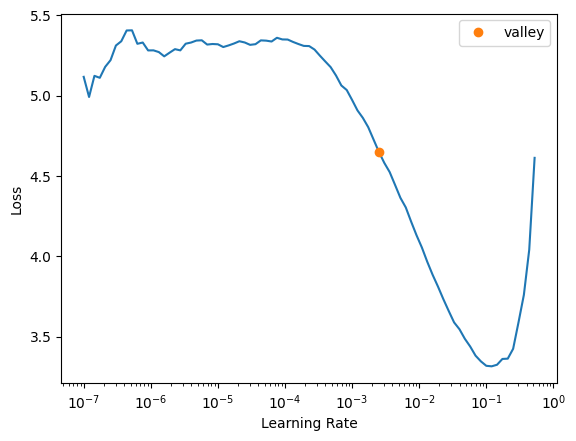

In [39]:
learn.lr_find()

In [40]:
learn.fit_one_cycle(5, lr_max=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.924101,0.438234,0.120433,01:10
1,0.597453,0.330050,0.101489,01:08
2,0.418815,0.315692,0.090663,01:09
3,0.239699,0.251023,0.074425,01:07
4,0.173242,0.241043,0.069012,01:07


In [41]:
learn.save('resnet50')

Path('models/resnet50.pth')

In [45]:
learn.fit_one_cycle(2, 4e-4)


epoch,train_loss,valid_loss,error_rate,time
0,0.481136,0.458067,0.133965,01:22
1,0.267266,0.315682,0.094046,01:22


In [46]:
learn.save('resnet50')

Path('models/resnet50.pth')

In [47]:
learn.export('pet_breeds_model.pkl')

